In [1]:
!pip install --quiet git+https://github.com/EgorDudyrev/paspailleur.git
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [2]:
from importlib import reload

In [3]:
from script import clustering as clib, visual_lib as vlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from functools import reduce
from bitarray import frozenbitarray

# Test examples on Circles data

In [5]:
from sklearn import datasets

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

In [6]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
X, y = blobs

In [7]:
linscale_x = np.linspace(X[:,0].min()-0.01, X[:,0].max()+0.01, 11)
linscale_y = np.linspace(X[:,1].min()-0.01, X[:,1].max()+0.01, 11)
ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])

In [8]:
min_support = 0.01
max_support = 0.8
min_delta_stability = 0.01

In [9]:
data = list(ps.preprocess_data(X))
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_support))
print(len(attributes))

37


In [10]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_support,
    use_tqdm=True, n_attributes=len(attributes)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
print(f"n extents", len(stable_extents))

  0%|          | 0/37 [00:00<?, ?it/s]

n extents 697
CPU times: user 18.6 ms, sys: 7.25 ms, total: 25.8 ms
Wall time: 25 ms


In [11]:
from bitarray.util import count_and, count_or

jaccard_thold = 0.9
min_added_coverage = 75
sparse_extents = []
for i, extent in enumerate(stable_extents):
    if extent.count() < min_added_coverage:
        continue
        
    not_like_others = all(count_and(extent, other)/count_or(extent, other) <= jaccard_thold
                          for other in sparse_extents)
    if not_like_others:
        sparse_extents.append(extent)
print(len(stable_extents), len(sparse_extents))

697 220


In [12]:
%%time
clusterings = list(clib.mine_clusterings(sparse_extents, min_support=450, max_length=5,
                                         min_added_coverage=min_added_coverage))
print(len(clusterings))

7638
CPU times: user 2.34 s, sys: 10.6 ms, total: 2.35 s
Wall time: 2.35 s


In [13]:
print(max(map(len, clusterings)))

5


In [14]:
clib = reload(clib)

In [15]:
concepts_dict = clib.mine_clusters_info(sparse_extents, attr_extents, ps, data, 0, 1)

In [16]:
weight_params = dict(
    overlap_weight=0.2,
    n_concepts_weight=0.1,
    imbalance_weight=0.1,
    stability_weight=0.2,
    complexity_weight=0.1,
    n_concepts_max=5,
)
clusterings_dict = {
    idxs: clib.clustering_reward2(idxs, concepts_info=concepts_dict, **weight_params)[1]
    for idxs in clusterings
}
clusterings_df = pd.DataFrame(clusterings_dict).T
clusterings_df.index = clusterings

In [17]:
clusterings_df['density'] = [np.mean([concepts_dict['density'][i] for i in idxs]) for idxs in clusterings_df.index]

In [18]:
clusterings_df.head()

,coverage,overlap,n_concepts,imbalance,stability,complexity,density
"(0,)",0.996,0.000000,0.2,0.000000,0.115385,0.50,4.278075
"(3, 7)",0.996,0.594378,0.4,0.068155,0.105769,0.50,4.730153
"(3, 14)",0.994,0.512048,0.4,0.127790,0.115385,0.75,5.172836
"(3, 22)",0.996,0.457831,0.4,0.164708,0.096154,0.50,5.277237
"(3, 69)",0.994,0.248996,0.4,0.313796,0.115385,0.75,5.196595


In [19]:
if 'reward' in clusterings_df.columns:
    clusterings_df = clusterings_df.drop(columns='reward')
    
weight_params['density_weight'] = 5
weight_params['stability_weight'] = 1
weight_params['overlap_weight'] = 2
weight_params['imbalance_weight'] = 2

signs = np.array([1 if f in {'coverage', 'stability', 'density'} else -1 for f in clusterings_df])
weights = np.array([1 if f == 'coverage' else weight_params[f"{f}_weight"] for f in clusterings_df])

clusterings_df['reward'] = (clusterings_df/clusterings_df.max()*weights*signs).sum(1)

In [20]:
clusterings_df = clusterings_df.sort_values('reward', ascending=False)

In [21]:
clusterings_df.head()

,coverage,overlap,n_concepts,imbalance,stability,complexity,density,reward
"(119, 132, 171, 210)",0.906,0.000000,0.8,0.059032,0.442308,1.0,10.060758,5.851992
"(95, 115, 124)",0.904,0.000000,0.6,0.031195,0.256410,1.0,9.980425,5.566572
"(96, 119, 171, 210)",0.912,0.066265,0.8,0.080678,0.466346,1.0,9.823430,5.536407
"(180, 187, 188, 191, 196)",0.920,0.000000,1.0,0.006660,0.215385,1.0,9.908845,5.530335
"(62, 119, 163)",0.920,0.000000,0.6,0.104963,0.320513,1.0,10.239248,5.515691


In [22]:
concepts_df = pd.DataFrame(concepts_dict)

In [23]:
n_clusters_max = 5

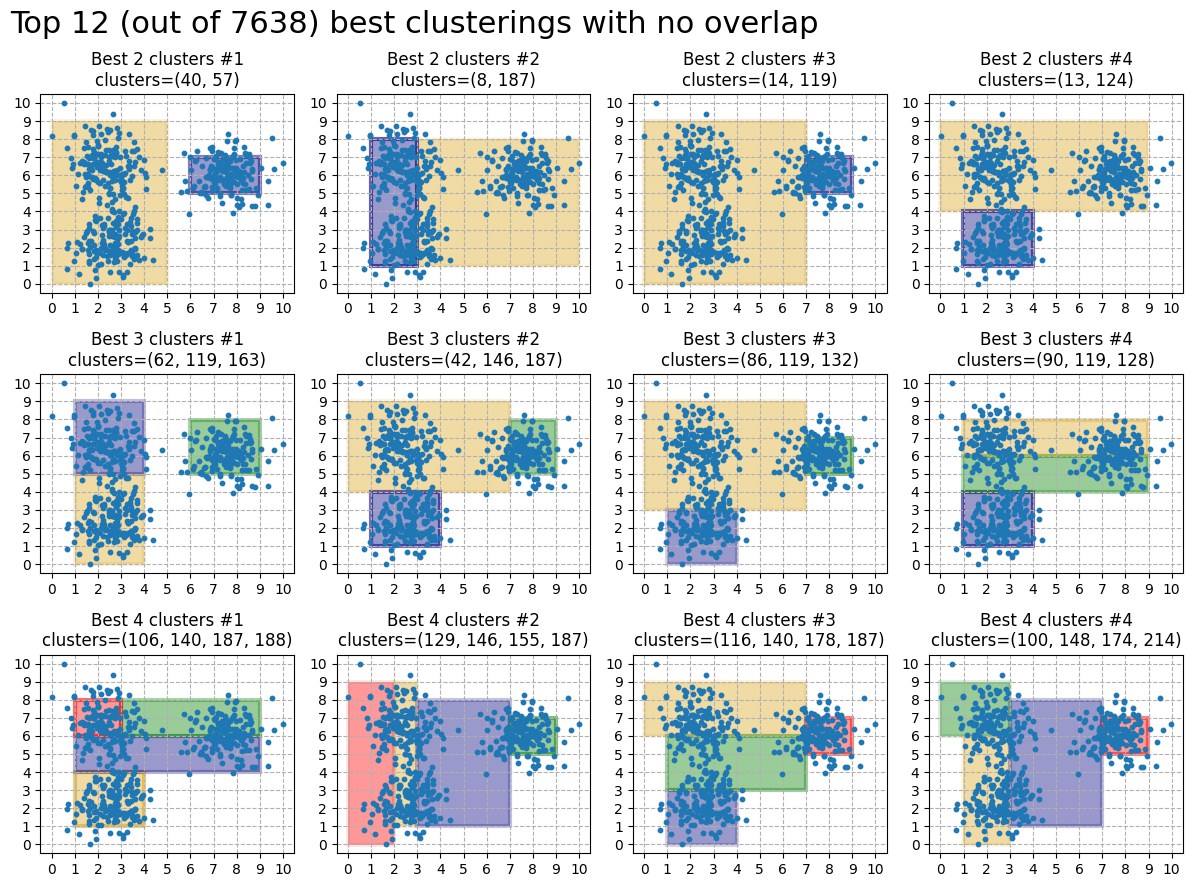

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for row_idx, n_clusters in enumerate(range(2,4+1)):
    flg = (clusterings_df['n_concepts']==n_clusters/n_clusters_max)&(clusterings_df['overlap']==0)
    best_clusterings = clusterings_df[flg]
    for i, (ax, best_clustering) in enumerate(zip(axs[row_idx], best_clusterings.index), start=1):
        vlib.init_axis(ax, f"Best {n_clusters} clusters #{i}\nclusters={best_clusterings.index[i]}", 
                       linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), 
                       grid_params=dict(zorder=0, linestyle='--'))

        ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
        vlib.draw_clustering(ax, best_clustering, concepts_df)

fig.suptitle(f'Top {len(axs.flatten())} (out of {len(clusterings_df)}) best clusterings with no overlap',
             size=22, ha='left', x=0.01)
fig.tight_layout()
fig.subplots_adjust()
# ax.legend(loc='lower right')
fig.savefig('../figures/best_clustersNOLAP_blops.pdf')
plt.show()